<a href="https://colab.research.google.com/github/PaulinaRuizB/Machine_Learning_Theory/blob/main/Homeworks/Task_4_MSE_polynomialfeatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Explicación matemática del código

### 1. Señal y ruido
La señal limpia que generamos es una onda sinusoidal:

$$
t^*(x) = A \, \sin(2 \pi F_0 x)
$$

donde:
- \(A\) es la amplitud,
- \(F_0\) es la frecuencia fundamental,
- \(x\) son los instantes de muestreo.

El ruido gaussiano añadido se controla con la **relación señal a ruido (SNR)** en decibelios:

$$
\text{SNR}_{dB} = 10 \log_{10} \left( \frac{P_x}{P_n} \right)
$$

de donde se despeja la potencia del ruido:

$$
P_n = \frac{P_x}{10^{\text{SNR}_{dB}/10}}
$$

y su varianza (asumiendo ruido blanco gaussiano) es:

$$
\sigma_n^2 = P_n
$$

Por lo tanto, la señal observada es:

$$
t(x) = t^*(x) + n(x), \quad n(x) \sim \mathcal{N}(0, \sigma_n^2).
$$

---

### 2. Representación polinómica
Para aproximar la señal, construimos un **vector de características polinómicas**:

$$
\phi_Q(x) = \begin{bmatrix}
x, \; x^2, \; \dots, \; x^Q
\end{bmatrix}
$$

donde \(Q\) es el **grado del polinomio** (la complejidad del modelo).

---

### 3. Regresión lineal
El modelo polinómico busca una combinación lineal de esas características:

$$
\hat{t}(x) = w_0 + w_1 x + w_2 x^2 + \dots + w_Q x^Q
= \mathbf{w}^\top \phi_Q(x) + b
$$

donde:
- \(\mathbf{w}\) son los coeficientes,
- \(b\) es el intercepto o término constante.

El ajuste de los parámetros se hace minimizando el **Error Cuadrático Medio (ECM)**:

$$
\min_{\mathbf{w}, b} \; \frac{1}{N} \sum_{i=1}^N \big( t(x_i) - \hat{t}(x_i) \big)^2
$$

Esto corresponde a **Mínimos Cuadrados Ordinarios (OLS)**.

---

### 4. Error de predicción y error real
- **Error de predicción (ECM contra datos ruidosos):**

$$
\text{ECM}_{\text{pred}} = \frac{1}{N} \sum_{i=1}^N \big( t(x_i) - \hat{t}(x_i) \big)^2
$$

- **Error real (ECM contra señal verdadera):**

$$
\text{ECM}_{\text{real}} = \frac{1}{N} \sum_{i=1}^N \big( t^*(x_i) - \hat{t}(x_i) \big)^2
$$

---

### 5. Validación cruzada (Cross-validation)
Para estimar el error de **generalización**, usamos **K-fold Cross Validation**:

1. Se divide el dataset en \(K\) bloques (folds).
2. Para cada fold \(k\):
   - Se entrena con \(K-1\) bloques,
   - Se evalúa en el bloque restante.
3. El error de test por CV es el promedio:

$$
\text{ECM}_{CV} = \frac{1}{K} \sum_{k=1}^K
\left[
\frac{1}{|D_{test}^{(k)}|} \sum_{x_i \in D_{test}^{(k)}}
\big( t(x_i) - \hat{t}(x_i) \big)^2
\right]
$$

---

### 6. Relación con la complejidad
Al aumentar el grado del polinomio \(Q\):

- El **error de entrenamiento** nunca crece (siempre puede ajustarse mejor).  
- El **error de test (CV)** sigue típicamente una **curva en U**:
  - Grande para modelos simples (subajuste, alto sesgo),
  - Mínimo en un punto intermedio (modelo adecuado),
  - Grande para modelos muy complejos (sobreajuste, alta varianza).


## Librerías

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression

#solución min cuadrados regularizados
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_squared_error as MSE

In [ ]:
#función cálculo varianza del ruido a partir del snr dB
def var_snr(x,snrdB): #x vector de datos (señal), snrdB SNR en dB
    Px = np.mean(x**2)#estimador potencia media de la señal
    return Px/(10**(snrdB/10))

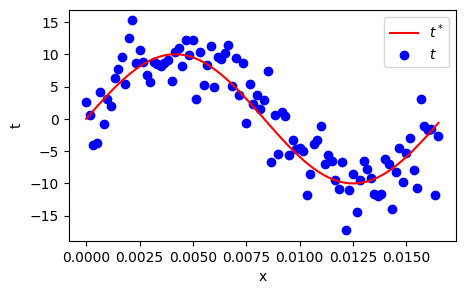

In [ ]:
#datos simulados
Fo = 60 #frecuencia fundamental señal cos
A = 10 # amplitud de la señal
To = 1/Fo #periodo fundamental
Fs = 100*Fo #frecuencia muestreo según nyquist Fs >= 2 Fo
X = np.arange(0,To,1/Fs) #vector de entrada en un periodo con pasos según período de muestreo

snrdB = 5 #ruido según SNR dB
#señal limpia - objetivo
tt = A*np.sin(2*np.pi*Fo*X)
#modelo con función sinoidal contaminada con ruido Gaussiano
t = A*np.sin(2*np.pi*Fo*X) + np.sqrt(var_snr(tt,snrdB))*np.random.randn(len(X))

X = X.reshape(-1,1)#filas = realizaciones-muestras
t = t.reshape(-1,1)

plt.figure(figsize=(5,3))
plt.plot(X,tt,c='r',label='$t^*$')
plt.scatter(X,t,c='b',label='$t$')
plt.legend()
plt.xlabel('x')
plt.ylabel('t')
plt.show()


0


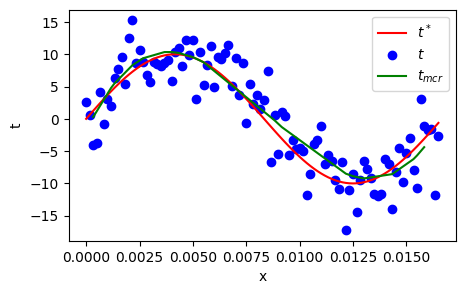

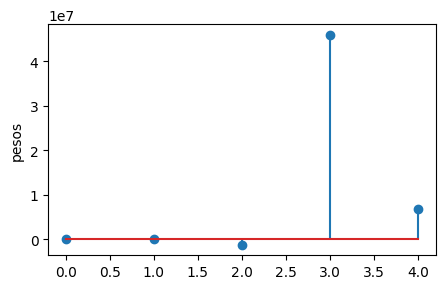

In [ ]:
#generación representación polinomial
#desde la libreria sklearn
Q = 4#grado del polinomio
phiQ = PolynomialFeatures(degree=Q)
Phi = phiQ.fit_transform(X)#representar datos desde polinomio

#particionar datos
rs = ShuffleSplit(n_splits=1, random_state=0, test_size=0.2)
for i, (train_i, test_i) in enumerate(rs.split(X)):
   print(i)


#regresor
lambdaR = 1e-15#hiperparámetro de regularización
reg_mc = Ridge(alpha=lambdaR)

train_i = np.sort(train_i)
test_i = np.sort(test_i)

reg_mc.fit(Phi[train_i],t[train_i])

t_mc = reg_mc.predict(Phi[test_i])

plt.figure(figsize=(5,3))
plt.plot(X,tt,c='r',label='$t^*$')
plt.scatter(X,t,c='b',label='$t$')
plt.plot(X[test_i],t_mc,c='g',label='$t_{mcr}$')

plt.legend()
plt.xlabel('x')
plt.ylabel('t')
plt.show()

plt.figure(figsize=(5,3))
plt.stem(reg_mc.coef_)
plt.ylabel('pesos')
plt.show()

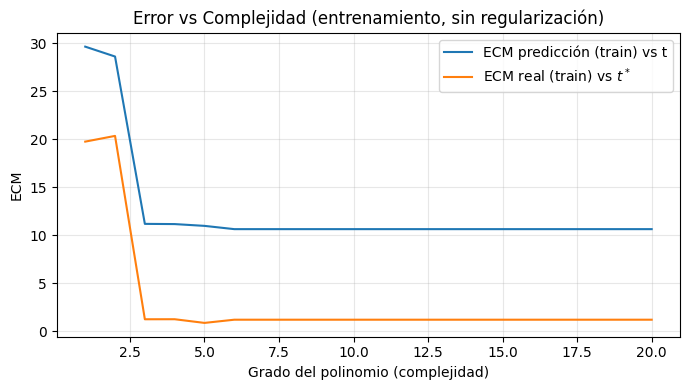

In [ ]:
Qmax = 20
grados = range(1, Qmax+1)
ecm_pred, ecm_real = [], []

for Q in grados:
    phi = PolynomialFeatures(degree=Q, include_bias=False)  # evita sesgo duplicado
    Phi = phi.fit_transform(X)

    reg = LinearRegression(fit_intercept=True)
    reg.fit(Phi, t.ravel())

    yhat = reg.predict(Phi)
    ecm_pred.append(MSE(t.ravel(),  yhat))   # contra t (ruidosa) -> “predicción” en train
    ecm_real.append(MSE(tt.ravel(), yhat))   # contra t* (real)    -> “error real” en train

plt.figure(figsize=(7,4))
plt.plot(grados, ecm_pred, label='ECM predicción (train) vs t')
plt.plot(grados, ecm_real, label='ECM real (train) vs $t^*$')
plt.xlabel('Grado del polinomio (complejidad)'); plt.ylabel('ECM')
plt.title('Error vs Complejidad (entrenamiento, sin regularización)')
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()


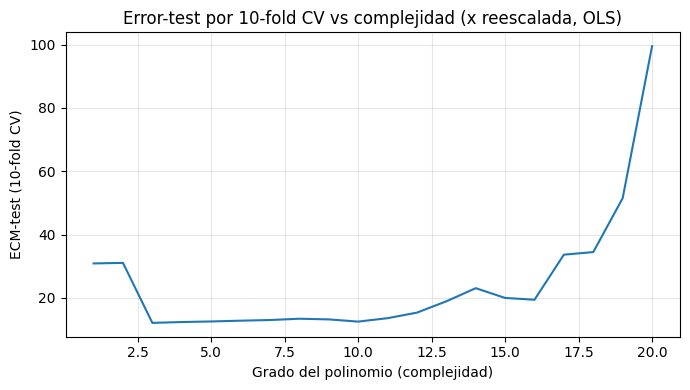

In [ ]:
# 1) Reescalar X a [-1, 1]
x_unit = 2*(X - X.min())/(X.max() - X.min()) - 1

# 2) (Opcional) Aumentar ruido para ver mejor la U
#    Cambia snrdB antes de generar t. Si ya generaste t con 10 dB, reházlo con 0 dB:
# snrdB = 0
# noise = np.sqrt(var_snr(tt, snrdB)) * np.random.randn(len(X))
# t = (tt + noise).ravel()

# 3) Configurar 10-fold CV
cv = KFold(n_splits=10, shuffle=True, random_state=0)

Qmax = 20        # aumenta el tope de grados
grados = range(1, Qmax+1)

ecm_cv = []

for Q in grados:
    # Polinomio + OLS (sin regularización) para resaltar sobreajuste
    model = make_pipeline(
        PolynomialFeatures(degree=Q, include_bias=False),
        LinearRegression(fit_intercept=True)
    )
    scores = cross_val_score(model, x_unit, t.ravel(),
                             scoring="neg_mean_squared_error", cv=cv)
    ecm_cv.append(-scores.mean())

plt.figure(figsize=(7,4))
plt.plot(grados, ecm_cv)
plt.xlabel('Grado del polinomio (complejidad)')
plt.ylabel('ECM-test (10-fold CV)')
plt.title('Error-test por 10-fold CV vs complejidad (x reescalada, OLS)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
